# EOS 202 - Final Project

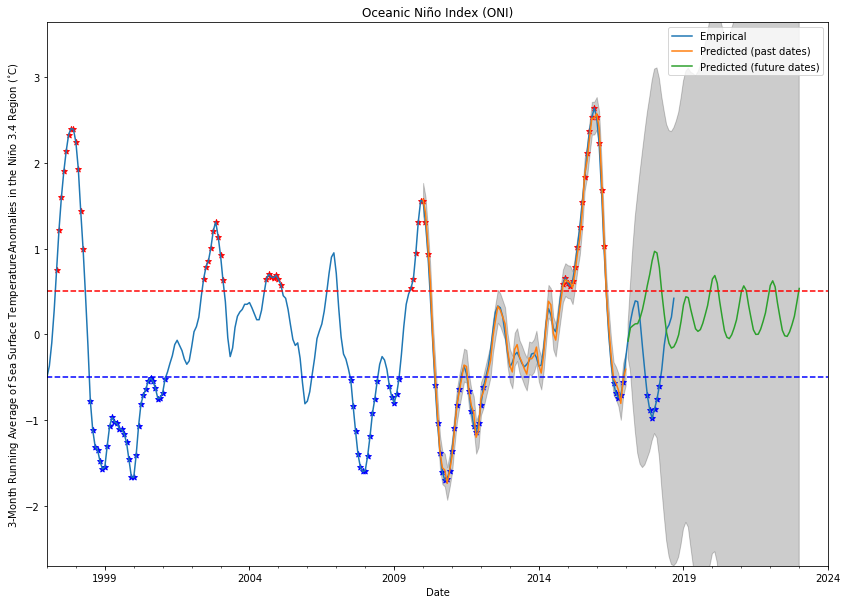

The Mean Squared Error of the predictor is 0.92.
The Root Mean Squared Error of the predictor is 0.96.


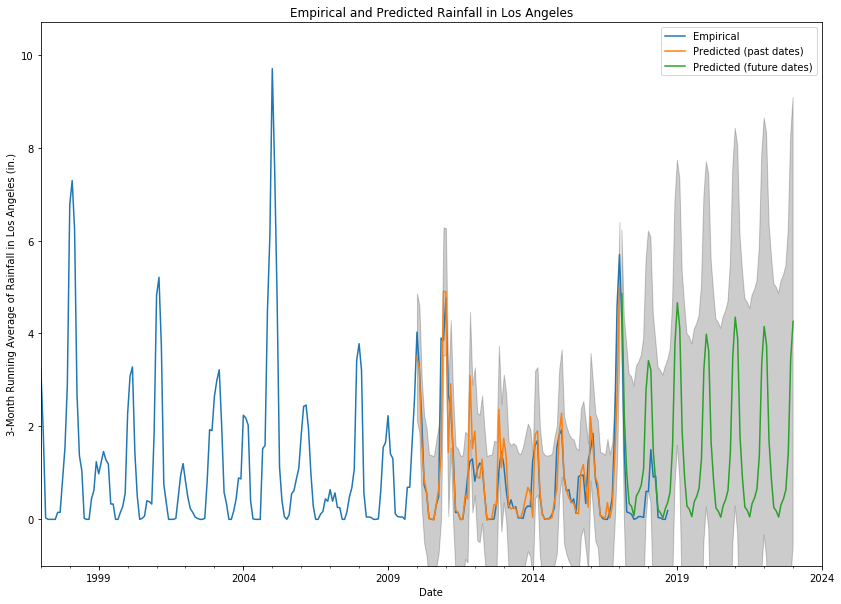

The Mean Squared Error of the predictor is 1.32.
The Root Mean Squared Error of the predictor is 1.15.


In [2]:
# Tommy Monson
# Training an ARIMA Predictor with ENSO Data

%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import itertools
import statsmodels.api as sm
import sys
from __future__ import unicode_literals
from statsmodels.tsa.stattools import acf, pacf


filepath = '/home/tkmonson/Documents/enso_predictor/'
dataNames = ['anomaly','rainfall']
dates = pd.date_range(start='02/01/1950', end='9/01/2018', freq='MS')

for dataName in dataNames:
    
    # ----- DATA PREPROCESSING -----

    # Fill DataFrame with data: [year, month, sst, sstAvg, anomaly] and [year, month, rainfall]
    # sst:     the monthly average sst, averaged across all buoys in the Niño 3.4 region
    # sstAvg:  the average sst over 30 years, centered around the corresponding date
    # anomaly: sst - sstAvg
    # rainfall: downtown Los Angeles (inches)
    
    df = pd.read_csv(filepath + dataName + '.csv')

    data3MM = []
    for i in range(1,len(df.index)-1):
        data3MM.append(round(df.iloc[i-1:i+2,:][dataName].mean(),2)) # 3 month running averages

    df = pd.DataFrame(data = data3MM,
                      index = dates,
                      columns = [dataName])

    train = df.loc[:'2017-01-01']


    # ----- HYPERPARAMETER OPTIMIZATION -----

    # These hyperparameters were found mostly through reading theory and trial and error.
    order =  (2,0,2)
    seasonal_order = (1,1,0,12)

    # This code finds "optimal" hyperparameters, but for some data, hand-selecting works better.
    findHp = False
    if(findHp):
        p = d = q = range(0,3)
        s = 12 # this is not the optimal choice of periodicity, but it is a good estimate
        pdq = list(itertools.product(p,d,q))
        seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
        minAIC = np.inf

        # Test all combinations of hyperparameters
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(train,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = model.fit()
                    print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                    if results.aic < minAIC:
                        order = param
                        seasonal_order = param_seasonal
                        minAIC = results.aic
                except:
                    continue
        print('Order: {}, Seasonal Order: {}'.format(order, seasonal_order))


    # ----- ARIMA MODEL TRAINING -----

    model = sm.tsa.statespace.SARIMAX(train,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = model.fit()


    # ----- FORECASTING -----

    empiricalStart = '1997-01-01'
    predictedStart = '2010-01-01'
    predictedEnd =   '2024-01-01'

    # Plot empirical data (ONI SST anomalies)
    dfPlot = df.loc[empiricalStart:][dataName]
    ax = dfPlot.plot(label='Empirical')

    # Plot predictor's output for some recent dates
    pred = results.get_prediction(start=predictedStart, dynamic=False)
    pred.predicted_mean.plot(ax=ax, label='Predicted (past dates)', figsize=(14, 10))

    # Plot predictor's output for a few years of future dates
    pred_future = results.get_forecast(steps=72)
    pred_future.predicted_mean.plot(ax=ax, label='Predicted (future dates)')

    # Plot confidence intervals for the predictor output
    for ci in [pred.conf_int(), pred_future.conf_int()]:
        ax.fill_between(ci.index,
                        ci.iloc[:, 0],
                        ci.iloc[:, 1], color='k', alpha=.2)

    # Labels and such
    plt.xlim(empiricalStart, predictedEnd)
    plt.ylim(dfPlot.min() - 1, dfPlot.max() + 1)
    ax.set_xlabel('Date')
    if dataName == dataNames[0]:
        ax.set_ylabel('3-Month Running Average of Sea Surface Temperature' +
                      'Anomalies in the Niño 3.4 Region ($^{\circ}$C)')
        ax.set_title('Oceanic Niño Index (ONI)')
        
        # Plot ONI thresholds
        threshold = 0.5*np.ones(len(dates))
        ax.plot(threshold, color='r', linestyle='--')
        ax.plot(-threshold, color='b', linestyle='--')
        
        # Plot stars to mark El Niño / La Niña events
        blueStars = []
        redStars = []
        temp = []
        for i in dates:
            j = i.strftime('%Y-%m-%d')
            if j >= empiricalStart:
                if len(temp) == 0 and abs(dfPlot[j]) > 0.5:
                    temp.append(i)
                elif (dfPlot[j] < -0.5 and dfPlot[temp[-1].strftime('%Y-%m-%d')] < -0.5) or \
                     (dfPlot[j] > 0.5 and dfPlot[temp[-1].strftime('%Y-%m-%d')] > 0.5):
                    temp.append(i)
                else:
                    if len(temp) >= 5:
                        if dfPlot[temp[-1].strftime('%Y-%m-%d')] < 0:
                            blueStars += temp
                        else:
                            redStars += temp
                    temp = []
                    
        for i in blueStars:
            ax.scatter(i.strftime('%Y-%m-%d'), dfPlot[i.strftime('%Y-%m-%d')], color='b', marker='*')
        for i in redStars:
            ax.scatter(i.strftime('%Y-%m-%d'), dfPlot[i.strftime('%Y-%m-%d')], color='r', marker='*')
        
    else:
        ax.set_ylabel('3-Month Running Average of Rainfall in Los Angeles (in.)')
        ax.set_title('Empirical and Predicted Rainfall in Los Angeles')
        
    plt.legend()
    plt.show()
    
    # Evaluate predictor error
    mse = ((df[dataName][predictedStart:'2017-01-01'] - pred.predicted_mean) ** 2).mean() + \
          ((df[dataName]['2017-02-01':] - pred_future.predicted_mean[:dates[-1].strftime('%Y-%m-%d')]) ** 2).mean()
    print('The Mean Squared Error of the predictor is {}.'.format(round(mse, 2)))
    print('The Root Mean Squared Error of the predictor is {}.'.format(round(np.sqrt(mse), 2)))